<h1><span style="color: Cyan;"> Objective 1: Image Classifier using CNN</span></h1>

<br>

|Name|Class|Admin Number|
|:----:|:----:|:----:|
|Muhammad Fitri Amir bin Abdullah|DAAA/FT/2B/06|2222811|


<br>

In this task, I aim to implement an image classifier using a Convolutional Neural Network in order to classify a dataset that contains 15 different types of vegetables. There are some steps given that I will need to adhere to such as: 
- converting the image into grayscale (1 channel instead of 3)
- making 1 model for 2 inputs, 31x31 pixels and 128x128 pixels, NOT 224.

Looking at the metadata of the dataset given, here's some useful information:
- Total 15 Classes of 3000 images; means that this is a multi-class classification task.
- Each class contain 200 images
- Size of each image is 224*224 and images are in *.jpg format.

<hr>

In [3]:
!pip install --quiet keras-tuner

In [11]:
pip install --quiet tensorflow

Note: you may need to restart the kernel to use updated packages.


## 1. Importing Packages

In [5]:
import numpy as np
import pandas as pd
import datetime
import os, time, math, datetime, warnings, pytz, glob, PIL

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import plotly.graph_objects as go
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from functools import reduce, wraps
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix


custom  = {"axes.edgecolor" : "white", 
            "grid.linestyle": "dashed",
            "grid.color": "gray"
            }
sns.set_style("whitegrid", rc = custom)

### 1a) Checking that GPU is used

In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17976915722486779140
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2254123828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10687980857566736494
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
!nvidia-smi

Thu Nov  2 14:31:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     4W /  N/A |    302MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
pip install --quiet opencv-python

Note: you may need to restart the kernel to use updated packages.


## 2. Exploratory Data Analysis

### 2a. Importing dataset and preparing test/train set

In [3]:
import os
import cv2
import numpy as np

dataset_path = "Datasets/Dataset for CA1 part A/"

# Initialize empty lists to store images and corresponding labels for training data
train_images = []
train_labels = []

# Loop through the training folder
train_folder_path = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder_path):
    label_path = os.path.join(train_folder_path, label)
    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255
        train_images.append(image)
        train_labels.append(label)

X_train = np.array(train_images)
y_train = np.array(train_labels)

# X train is the array containing all the images, while y train is the array containing all the labels
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (9028, 128, 128)
y_train shape: (9028,)


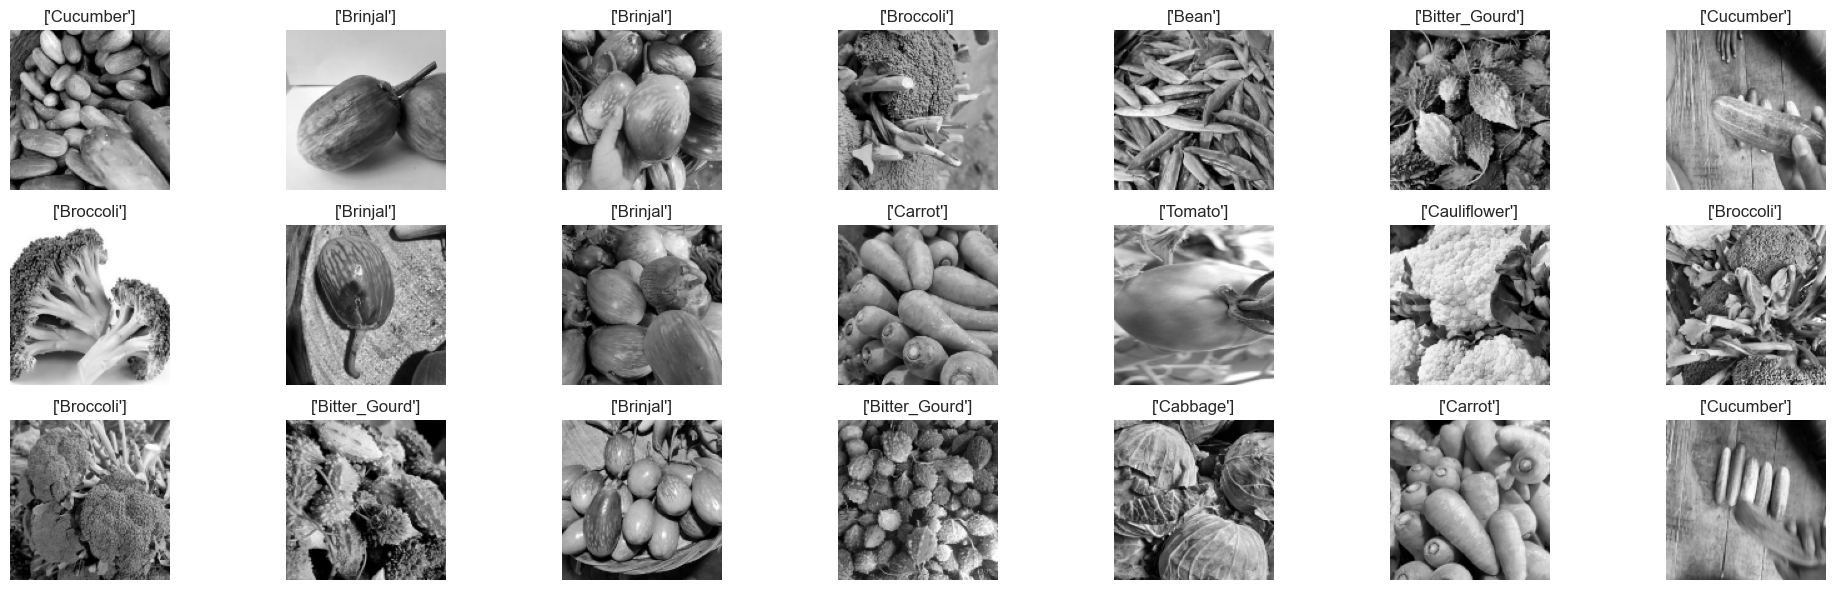

In [10]:
#Checking if the data was imported correctly

fig = plt.figure(figsize=(20, 6))
for i in range(1, 22):
    randn = int(np.random.random() * len(X_train))
    ax = fig.add_subplot(3, 7, i)
    ax.imshow(X_train[randn], cmap='gray')  # Use cmap='gray' to display grayscale images
    ax.set_title([y_train.flatten()[randn]])
    ax.axis('off')

plt.tight_layout()
plt.show()


## Feature engineering

In [ ]:
#Data Augmentation

## Baseline Modelling

## Model Improvement

# References

Dataset: <br>
https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset <br>
<hr>